In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import MFEA_base, AbstractModel, MFEA1
from MFEA_lib.model.utils import saveModel, loadModel, compareModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import SBX_CrossOver
from MFEA_lib.operators.Selection import ElitismSelection
from MFEA_lib.operators.Mutation import Polynomial_Mutation, NoMutation
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks

#### Build model

In [2]:
class SA_MFEA(AbstractModel):
    def renderRMP(self, title = None, figsize = None, dpi = 200):
        if figsize is None:
            figsize = (30, 30)
        if title is None:
            title = self.__class__.__name__
        fig = plt.figure(figsize= figsize, dpi = dpi)
        fig.suptitle(title, size = 15)
        fig.set_facecolor("white")

        for i in range (len(self.tasks)):
            for j in range (len(self.tasks)):
                r, c = min(i, j), max(i, j)
                if i != j: 
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(len(self.saved_rmp[r][c])), np.array(self.saved_rmp[r][c])[:, 0], label= 'task: ' +str(j + 1))
                    plt.legend()
                else:
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
                    plt.legend()
            plt.title('task ' + str( i + 1))
            plt.xlabel("Epoch")
            plt.ylabel("M_rmp")
            plt.ylim(bottom = -0.1, top = 1.1)

        return fig

    def success_history_memory_update(self, memory_M:np.ndarray, next_pos: np.ndarray, S: list, delta: list):
        for i in range(len(self.tasks)):
            for j in range(i+ 1, len(self.tasks)):
                if len(S[i][j]) != 0:
                    memory_M[i, j][next_pos[i][j]] =\
                        np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)
                    next_pos[i, j] = (next_pos[i, j] + 1) % memory_M.shape[2]
        return memory_M, next_pos

    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
        super().compile(cross_over, mutation, selection)
    
    def fit(self, tasks: list[AbstractFunc], MAXEVALS, num_inds_each_task=100, nb_inds_min = None, H = 30, sigmoid = 0.1,
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:
        np.random.seed(0)

        # LSA or SA
        if nb_inds_min is not None:
            assert num_inds_each_task >= nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
        pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

        # SA params:
        eval_k = np.zeros(len(tasks))
        max_Eval = int(MAXEVALS / len(tasks))
        epoch = 0

        # Initial success hitory memory M
        # NOTE
        M_rmp = np.ones((len(tasks), len(tasks), H))/2
        next_update_pos_M = np.zeros((len(tasks), len(tasks)), np.int)

        # mean and std of rmp each generations
        # len(tasks) * len(tasks) * generations * 2
        self.saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )
        epoch = 1

        # hisory rmp of this generation
        rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

        while np.sum(eval_k) <= MAXEVALS:
            
            S = np.empty((len(tasks), len(tasks), 0)).tolist()
            delta = np.empty((len(tasks), len(tasks), 0)).tolist()

            # initial offspring of generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))

            while len(offspring) < len(population):
                [idx_pa, idx_pb] = np.random.choice(len(population), size= 2, replace= False)
                [pa, pb], [skf_pa, skf_pb] = population[[idx_pa, idx_pb]], skill_factor_arr[[idx_pa, idx_pb]]

                if np.sum(eval_k) >= epoch * num_inds_each_task * len(tasks):
                    #save history
                    self.history_cost = np.append(self.history_cost, 
                        [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                        axis = 0
                    ) 

                    # save mean and std rmp
                    for i in range(len(tasks)):
                        for j in range(i + 1, len(tasks)):
                            if len(rmp_this_gen[i][j]) != 0:
                                mu = np.mean(rmp_this_gen[i][j])
                                std = np.std(rmp_this_gen[i][j])
                                self.saved_rmp[i][j].append([mu, std])

                    # hisory rmp of this generation
                    rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

                    #print
                    sys.stdout.write('\r')
                    sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
                        .format(epoch, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                        % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
                        )
                    sys.stdout.flush()

                    epoch += 1


                if skf_pa == skf_pb:
                    # Intra-crossover + mutate
                    oa, ob = self.cross_over(pa, pb, type= 'intra')
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                    eval_k[skf_oa] += 1
                    eval_k[skf_ob] += 1
                
                else:
                    # swap
                    if skf_pa > skf_pb:
                        pa, pb = pb, pa
                        skf_pa, skf_pb = skf_pb, skf_pa

                    # get rmp
                    mu = np.random.choice(M_rmp[skf_pa, skf_pb])
                    rmp = -1
                    while rmp <= 0:
                        rmp = np.random.normal(mu, sigmoid)
                        #bro Thang's random
                        # rmp = mu + sigmoid * np.sqrt(-2.0 * np.log(np.random.uniform()))\
                        #     * np.sin(2.0 * np.pi * np.random.uniform())
                    if rmp > 1: rmp = 1

                    # save generation's rmp
                    rmp_this_gen[skf_pa][skf_pb].append(rmp)

                    # Inter-TaskCrossover
                    if np.random.uniform() < rmp:
                        oa, ob = self.cross_over(pa, pb, type= 'inter')
                        oa, ob = self.mutation(oa), self.mutation(ob)
                        skf_oa, skf_ob = np.random.choice([skf_pa, skf_pb], size= 2, replace= True)
                        
                        # Evaluate oa, ob
                        fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                        eval_k[skf_oa] += 1
                        eval_k[skf_ob] += 1
                    else:
                        # select pa' and pb'
                        idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                        while idx_pa2 == idx_pa:
                            idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                        idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
                        while idx_pb2 == idx_pb:
                            idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])

                        pa2 = population[idx_pa2]
                        pb2 = population[idx_pb2]

                        oa, _ = self.cross_over(pa, pa2, type= 'intra')
                        ob, _ = self.cross_over(pb, pb2, type= 'intra')                      
                        oa, ob = self.mutation(oa), self.mutation(ob)
        
                        skf_oa, skf_ob = skf_pa, skf_pb

                        # Evaluate oa, ob
                        fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                        eval_k[skf_oa] += 1
                        eval_k[skf_ob] += 1

                    
                    # Calculate the maximum improvement percetage
                    Delta = 0
                    if skf_oa == skf_pa:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-10)
                        )
                    else:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pb] - fcost_oa)/(pop_fcost[idx_pb]+ 1e-10)
                        )
                    if skf_ob == skf_pa:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa]+ 1e-10)
                        )
                    else:
                        Delta = max(Delta, 
                            (pop_fcost[idx_pb] - fcost_ob)/(pop_fcost[idx_pb]+ 1e-10)
                        )
                    
                    if Delta > 0:
                        S[skf_pa][skf_pb].append(rmp)
                        delta[skf_pa][skf_pb].append(Delta)
                
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

            # update succes history memory 
            M_rmp, next_update_pos_M = self.success_history_memory_update(M_rmp, next_update_pos_M, S, delta)

            # merge
            population = np.append(population, offspring, axis = 0)
            skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
            pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

            # selection
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = min(((nb_inds_min - num_inds_each_task)/max_Eval * eval_k + num_inds_each_task).tolist(), [num_inds_each_task] * len(tasks))
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

        return self.solve, self.history_cost


#### Benchmark

##### CEC17

In [3]:
cec17_10tasks = CEC17_benchmark.get_10tasks_benchmark()

In [4]:
cross_over = SBX_CrossOver(nc = 2)
mutation= Polynomial_Mutation(nm = 5)
selection= ElitismSelection()

In [5]:
# model1 = MFEA1()
# model1.compile(
#     cross_over= cross_over,
#     mutation= mutation,
#     selection= selection
# )

# sol1, his1 = model1.fit(tasks= cec17_10tasks, num_generations= 1000, num_inds_each_task= 100, rmp =0.3, 
#                         evaluate_initial_skillFactor= True, num_epochs_printed= 10)

# saveModel(model1, "./RESULTS/cec17_mfea1.mso")

In [6]:
# base_model = MFEA_base()
# base_model.compile(
#     cross_over= cross_over,
#     mutation= mutation,
#     selection= selection
# )
# base_sol, base_his = base_model.fit(tasks= cec17_10tasks, num_generations= 1000, num_inds_each_task= 100, rmp =0.3,
#                                 evaluate_initial_skillFactor= True, num_epochs_printed= 10)

# saveModel(base_model, "./RESULTS/cec17_mfeabase.mso")

In [7]:
sa_model = SA_MFEA()
sa_model.compile(
    cross_over= cross_over,
    # mutation= mutation,
    mutation = NoMutation(),
    selection= selection
)
sa_sol, sa_his = sa_model.fit(tasks= cec17_10tasks, MAXEVALS= 100000 * len(cec17_10tasks), num_inds_each_task= 100, nb_inds_min = None, H = 30, sigmoid = 0.1,
                    evaluate_initial_skillFactor= True)

saveModel(sa_model, "./RESULTS/cec17_sa_mfea.mso")

Epoch 20, [>                   ]   2% ,pop_size: 1000, func_val: [48983.19464255871, 77166.997064082, 74263.24444935053, 25.37287382635256, 720989220.1528466, 21.021568162690727, 58.29288352524638, 14907.933060670013, 15.069907455488082, 16419.34800477169]04]7]

KeyboardInterrupt: 

In [8]:
lsa_model = SA_MFEA()
lsa_model.compile(
    cross_over= cross_over,
    # mutation= mutation,
    mutation = NoMutation(),
    selection= selection
)
lsa_sol, lsa_his = lsa_model.fit(tasks= cec17_10tasks, MAXEVALS= 1000000, num_inds_each_task= 100, nb_inds_min= 50, H = 30, sigmoid = 0.1,
                                evaluate_initial_skillFactor= True)

saveModel(lsa_model, "./RESULTS/cec17_lsa_mfea.mso")

Epoch 1000, [====================>] 100% ,pop_size: 495, func_val: [1.352088447164799e-15, 3.235322782040417e-17, 2.267089265987476e-20, 0.0, 1.4496948527024085e-13, 1.8575652127594822e-09, 1.4915713109076023e-10, 0.0006363783177221194, 0.0, 52.73277457088335]73277457686038]6]]]]0244761161]1]]4]]

'Saved'

In [9]:
print(sa_model.history_cost[-1], "\n", lsa_model.history_cost[-1])


[1.11202764e-09 3.90274999e-10 4.31939816e-12 0.00000000e+00
 1.67194066e-07 6.29177193e-06 5.18995853e-04 6.36380519e-04
 8.71257511e-11 3.88036130e+01] 
 [1.35208845e-15 3.23532278e-17 2.26708927e-20 0.00000000e+00
 1.44969485e-13 1.85756521e-09 1.49157131e-10 6.36378318e-04
 0.00000000e+00 5.27327746e+01]


In [10]:
model1 = loadModel("./RESULTS/cec17_mfea1.mso")

base_model = loadModel("./RESULTS/cec17_mfeabase.mso")

sa_model = loadModel("./RESULTS/cec17_sa_mfea.mso")

lsa_model = loadModel("./RESULTS/cec17_lsa_mfea.mso")

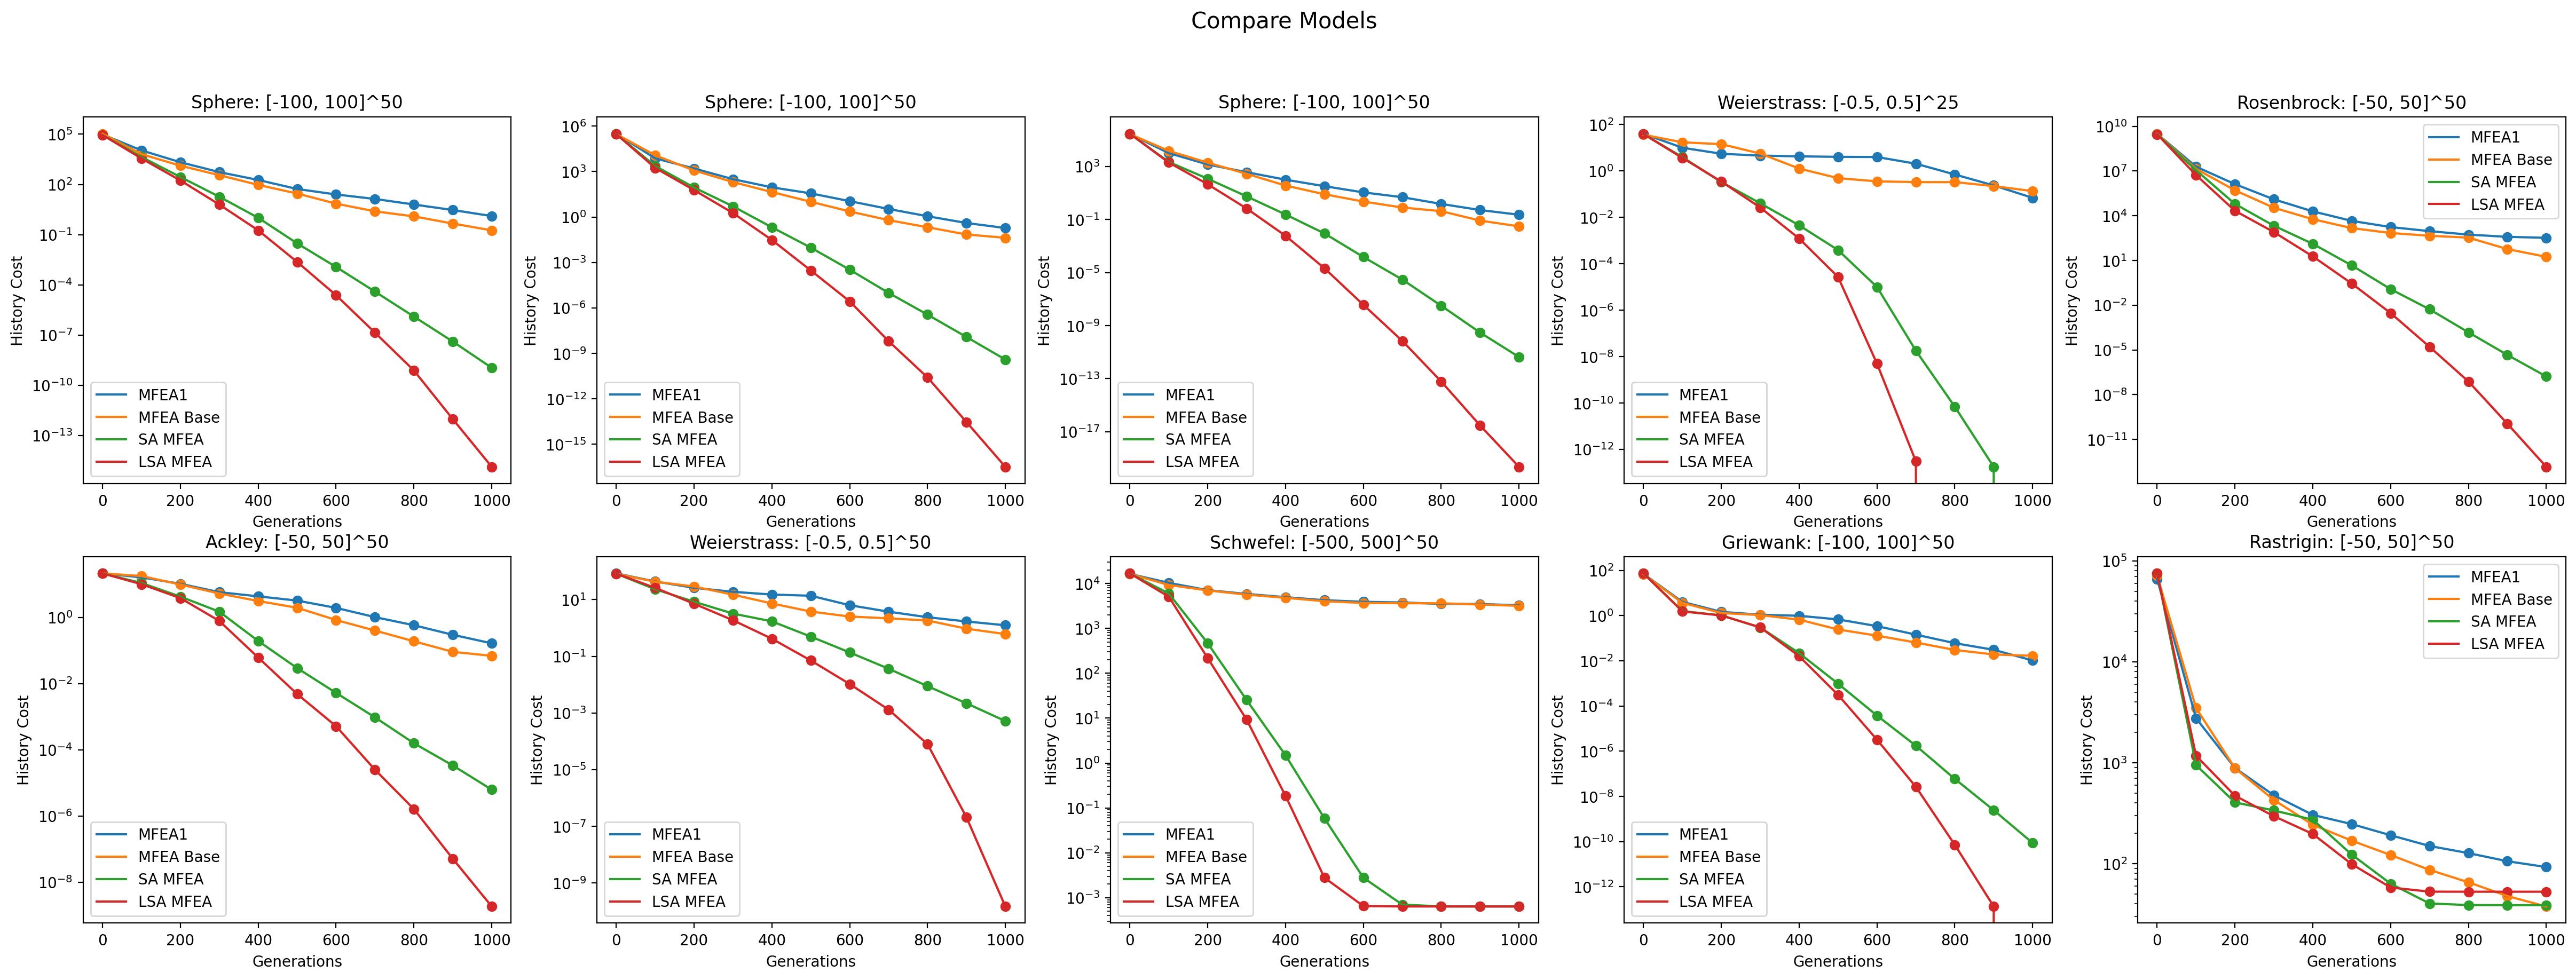

In [11]:
compareModel(
    models= [model1, base_model, sa_model, lsa_model],
    label_legend=  ["MFEA1", "MFEA Base", "SA MFEA", "LSA MFEA"],
    tasks= cec17_10tasks,
    shape= (2, 5),
    step= 100,
    yscale= 'log'
)
print()

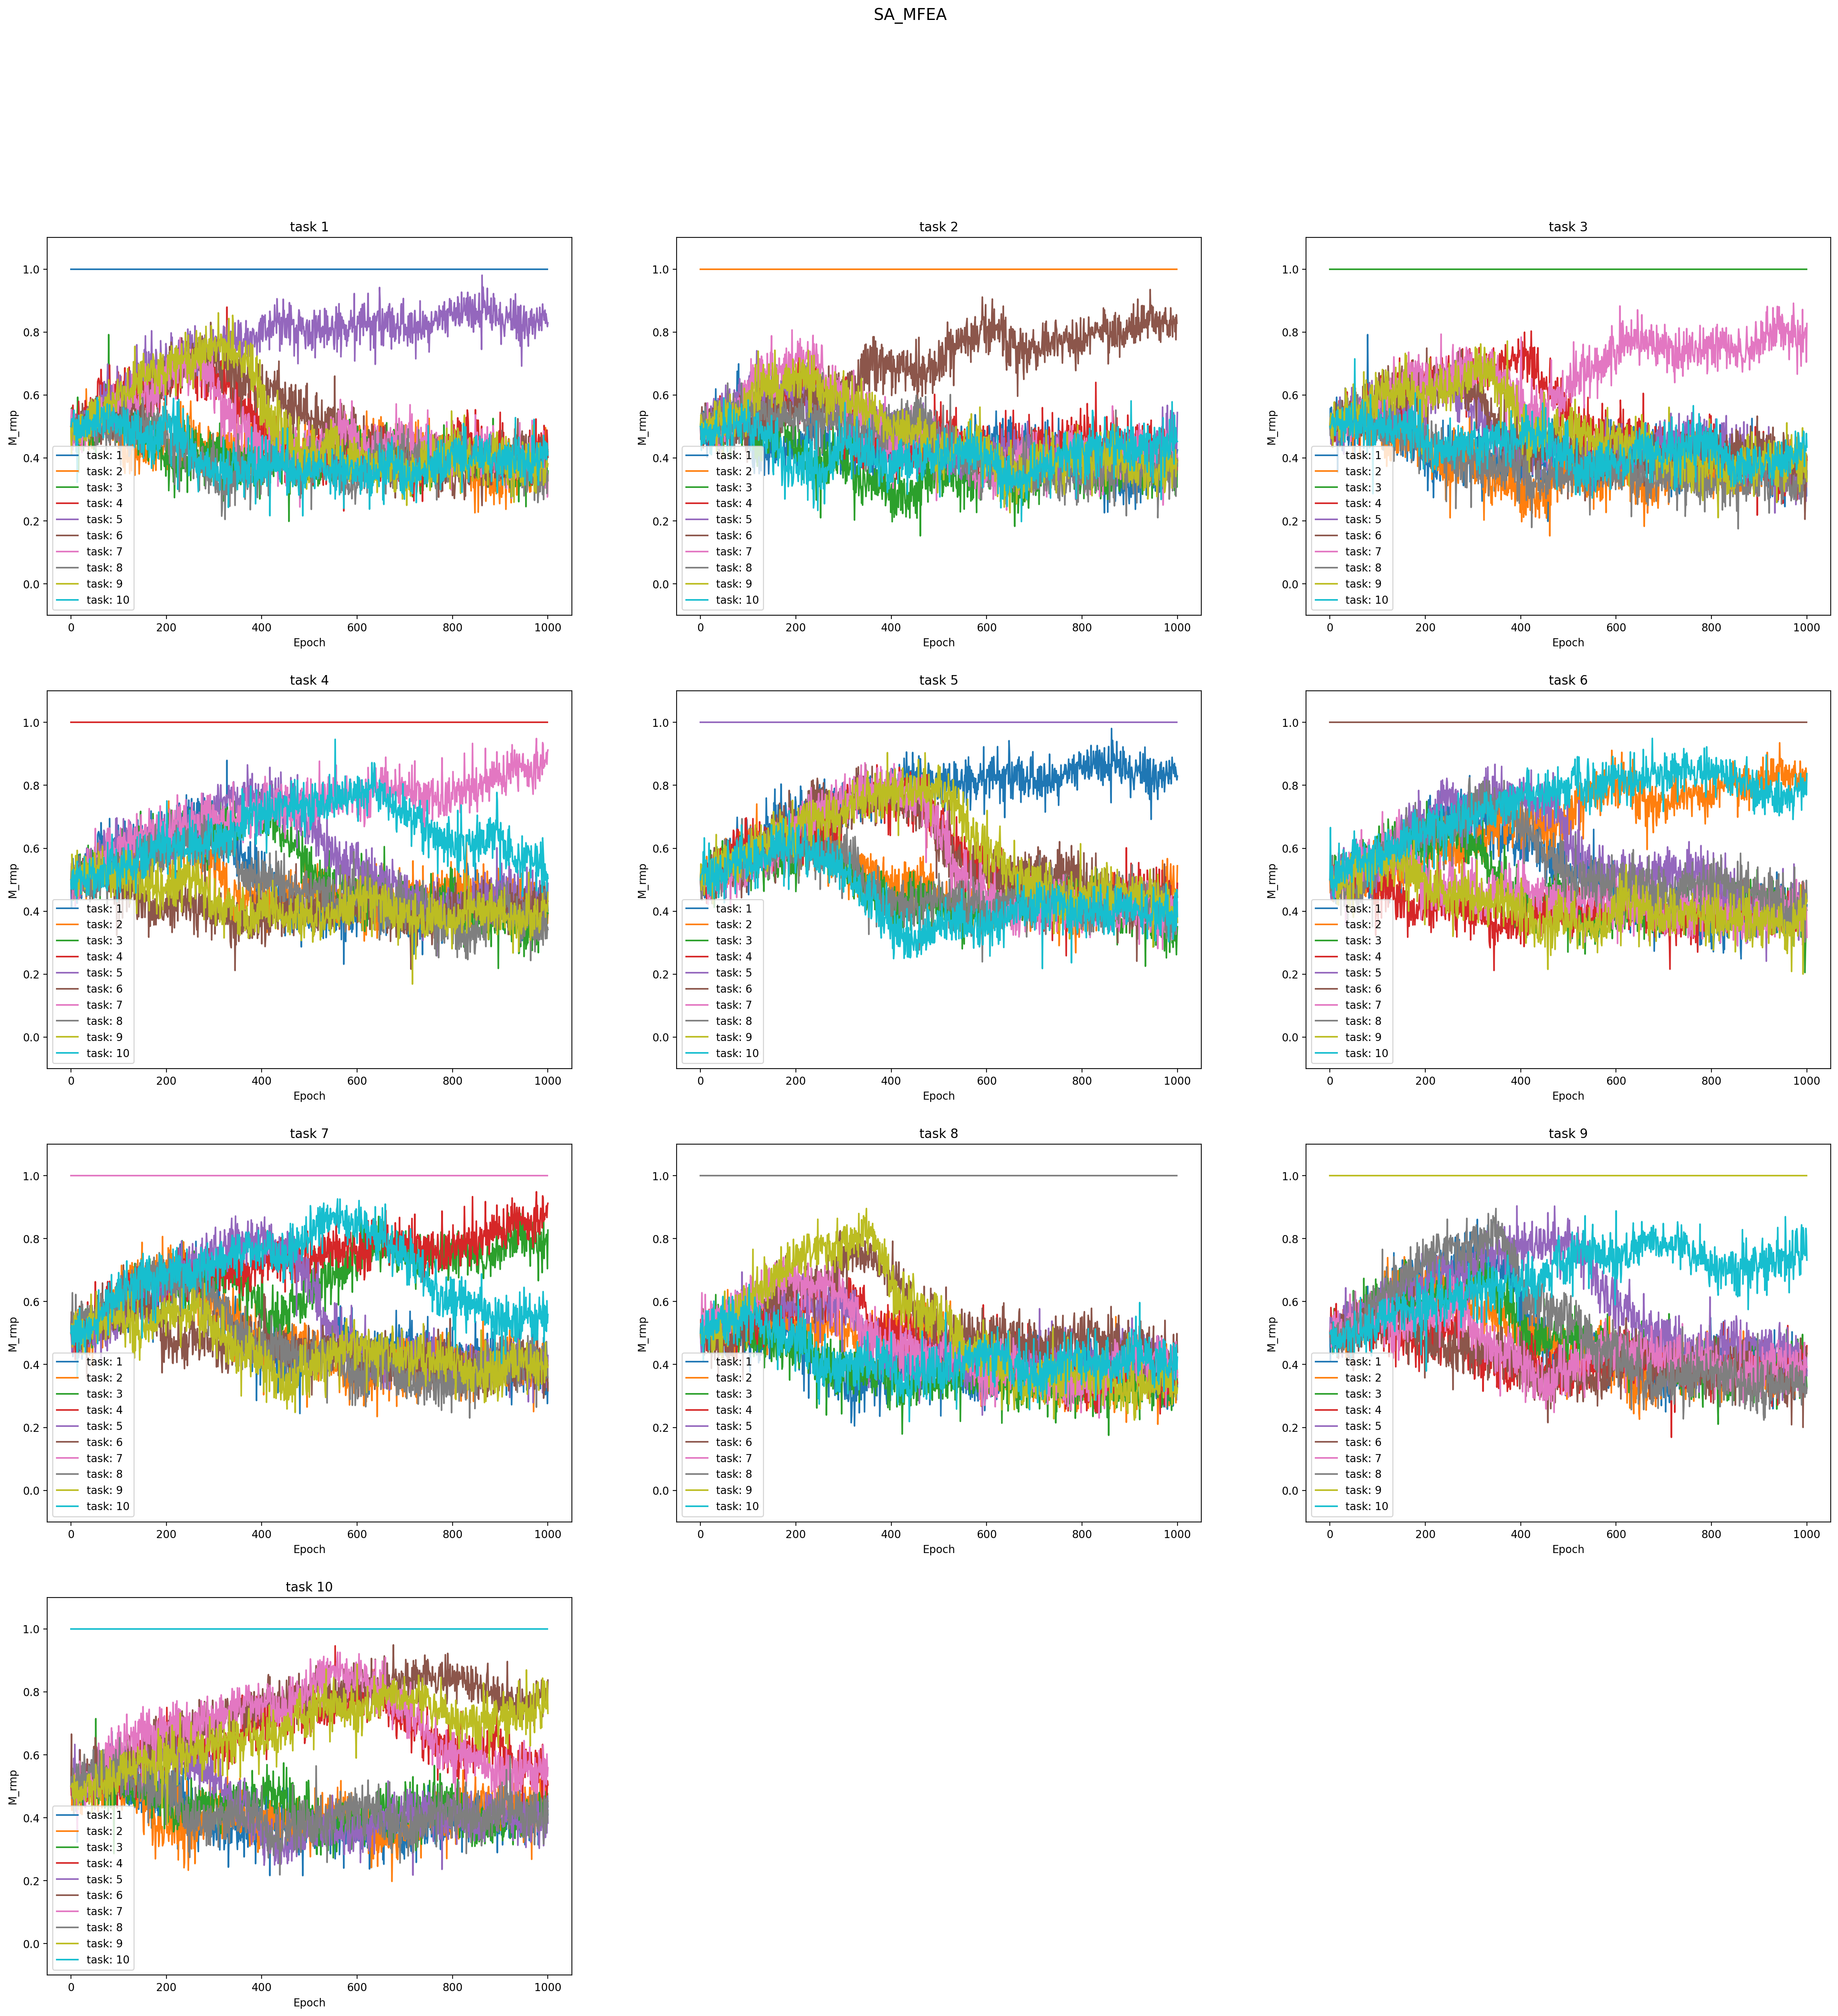

In [12]:
sa_model.renderRMP()
print()

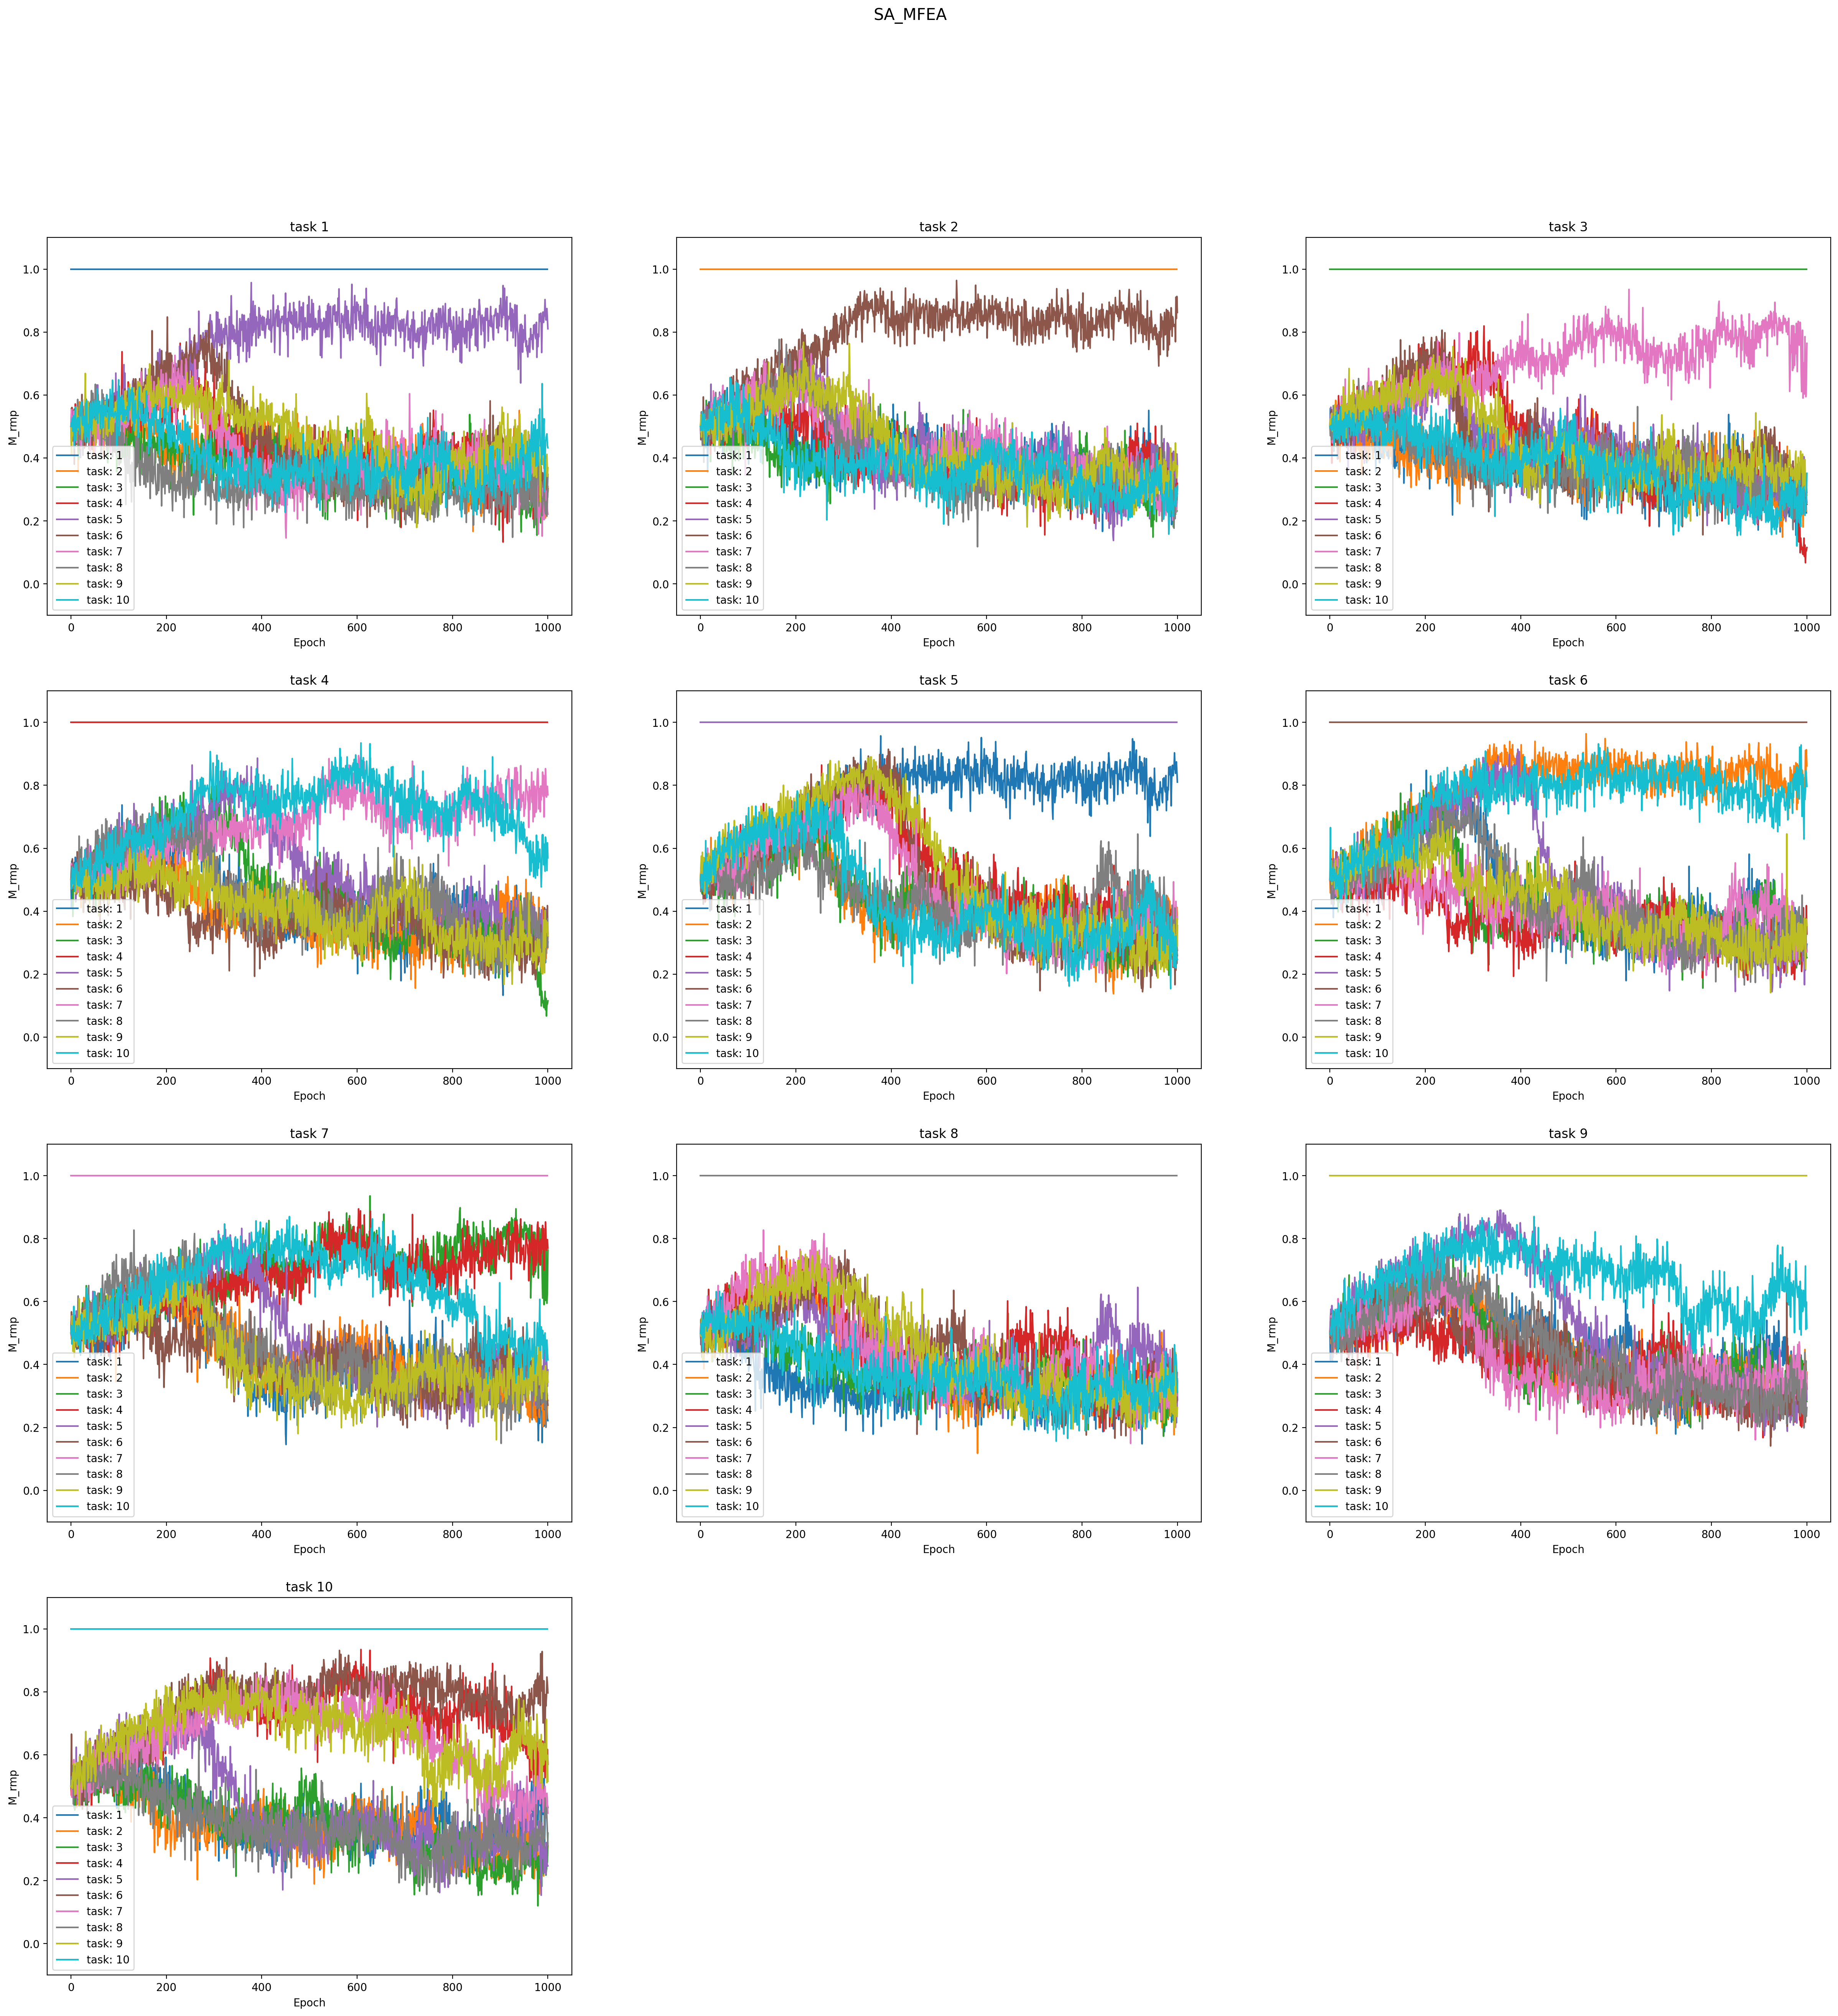

In [13]:
lsa_model.renderRMP()
print()

#### GECCO 20
